In [93]:
import warnings
warnings.filterwarnings('ignore')
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller

%matplotlib inline

In [84]:
pd.set_option('display.max_columns', 500)
import matplotlib 

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['ytick.labelsize'] = 18
plt.rcParams['figure.figsize'] = 12, 6

In [85]:

df = pd.read_csv('data/zillow_data.csv')

In [86]:
df.head(5)

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,1999-08,1999-09,1999-10,1999-11,1999-12,2000-01,2000-02,2000-03,2000-04,2000-05,2000-06,2000-07,2000-08,2000-09,2000-10,2000-11,2000-12,2001-01,2001-02,2001-03,2001-04,2001-05,2001-06,2001-07,2001-08,2001-09,2001-10,2001-11,2001-12,2002-01,2002-02,2002-03,2002-04,2002-05,2002-06,2002-07,2002-08,2002-09,2002-10,2002-11,2002-12,2003-01,2003-02,2003-03,2003-04,2003-05,2003-06,2003-07,2003-08,2003-09,2003-10,2003-11,2003-12,2004-01,2004-02,2004-03,2004-04,2004-05,2004-06,2004-07,2004-08,2004-09,2004-10,2004-11,2004-12,2005-01,2005-02,2005-03,2005-04,2005-05,2005-06,2005-07,2005-08,2005-09,2005-10,2005-11,2005-12,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,337600.0,338500.0,339500.0,340400.0,341300.0,342600.0,344400.0,345700.0,346700.0,347800.0,349000.0,350400.0,352000.0,353900.0,356200.0,358800.0,361800.0,365700.0,370200.0,374700.0,378900.0,383500.0,388300.0,393300.0,398500.0,403800.0,409100.0,414600.0,420100.0,426200.0,432600.0,438600.0,444200.0,450000.0,455900.0,462100.0,468500.0,475300.0,482500.0,490200.0,498200.0,507200.0,516800.0,526300.0,535300.0,544500.0,553500.0,562400.0,571200.0,579800.0,588100.0,596300.0,604200.0,612200.0,620200.0,627700.0,634500.0,641000.0,647000.0,652700.0,658100.0,663300.0,668400.0,673400.0,678300.0,683200.0,688300.0,693300.0,698000.0,702400.0,706400.0,710200.0,714000.0,717800.0,721700.0,725700.0,729900.0,733400.0,735600.0,737200.0,739000.0,740900.0,742700.0,744400.0,746000.0,747200.0,748000.0,749000.0,750200.0,752300.0,755300.0,759200.0,764000.0,769600.0,775600.0,781900.0,787900.0,793200.0,798200.0,803100.0,807900.0,812900.0,818100.0,823100.0,828300.0,834100.0,839800.0,845600.0,851800.0,858000.0,864400.0,870700.0,876200.0,880700.0,884400.0,887600.0,890500.0,893300.0,895500.0,897300.0,899000.0,900400.0,902000.0,904400.0,907100.0,909700.0,911900.0,913000.0,913000.0,912000.0,909300.0,905300.0,901400.0,897900.0,895400.0,893600.0,891100.0,887000.0,881700.0,875900.0,870300.0,865100.0,859000.0,851500.0,843800.0,836400.0,830700.0,827300.0,824800.0,821600.0,818300.0,814600.0,809800.0,803600.0,795500.0,786900.0,780700.0,776900.0,774700.0,774200.0,774400.0,774600.0,775600.0,777800.0,775200.0,767900.0,764700.0,766100.0,764100.0,759700.0,754900.0,746200.0,737300.0,730800.0,729300.0,730200.0,730700.0,730000.0,730100.0,730100.0,731200.0,733900.0,735500.0,735400.0,734400.0,737500.0,737700.0,733700.0,734000.0,740300.0,744600.0,750500.0,760400.0,771800.0,780600.0,

In [87]:
print(df[df['City']=='Chicago']['RegionName'].nunique())
print(df[df['State']=='DC']['RegionName'].nunique())
# print(df[df['Metro']=='Chicago']['RegionName'].nunique())

41
18


In [88]:
# get the DC data
dc_df = df[df['State']=='DC']
# drop unused columns
dc_df.drop(['RegionID','City','Metro','CountyName','SizeRank','State'],
           axis=1, inplace=True)
# get the list of zipcodes 
zipcodes = list(dc_df['RegionName'])
dc_df.drop(['RegionName'],axis=1,inplace=True)

In [89]:
dc_df_T = dc_df.transpose(copy=True)
dc_df_T.reset_index()
# dc_time_stamp = pd.DataFrame()
dc_df_T['date'] = pd.to_datetime(dc_df_T.index)
dc_df_T.set_index('date', inplace=True)
dc_df_T.columns = zipcodes
dc_df_T.head()

,20002,20009,20011,20019,20001,20020,20008,20003,20032,20016,20010,20007,20024,20017,20018,20037,20015,20012
date,,,,,,,,,,,,,,,,,,
1996-04-01,94300.0,178800.0,118900.0,91300.0,92000.0,104500.0,450100.0,130000.0,85700.0,362000.0,110500.0,358100.0,209800.0,121700.0,123000.0,277800.0,312400.0,185000.0
1996-05-01,94000.0,179200.0,118500.0,91000.0,92600.0,103800.0,448200.0,130100.0,85500.0,361200.0,111200.0,356000.0,208200.0,121400.0,122400.0,275800.0,311000.0,184900.0
1996-06-01,93700.0,179600.0,118200.0,90600.0,93200.0,103000.0,446300.0,130200.0,85400.0,360300.0,112000.0,353900.0,206600.0,121200.0,121800.0,273700.0,309800.0,184700.0
1996-07-01,93600.0,180000.0,117800.0,90400.0,93900.0,102200.0,444500.0,130400.0,85200.0,359400.0,112900.0,351700.0,205000.0,121000.0,121200.0,271600.0,308700.0,184400.0
1996-08-01,93400.0,180300.0,117600.0,90100.0,94600.0,101400.0,442900.0,130600.0,85000.0,358500.0,113800.0,349600.0,203300.0,120900.0,120700.0,269500.0,307900.0,184100.0


In [78]:
dc_df_T.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 265 entries, 1996-04-01 to 2018-04-01
Data columns (total 18 columns):
20002    265 non-null float64
20009    265 non-null float64
20011    265 non-null float64
20019    265 non-null float64
20001    265 non-null float64
20020    265 non-null float64
20008    265 non-null float64
20003    265 non-null float64
20032    265 non-null float64
20016    265 non-null float64
20010    265 non-null float64
20007    265 non-null float64
20024    265 non-null float64
20017    265 non-null float64
20018    265 non-null float64
20037    265 non-null float64
20015    265 non-null float64
20012    265 non-null float64
dtypes: float64(18)
memory usage: 39.3 KB


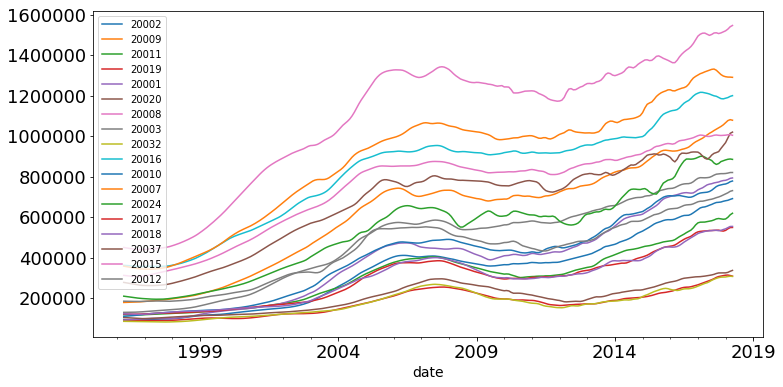

In [90]:
# check for NA
dc_df_T.plot()

In [201]:
zipcode = zipcodes[0]
ycut = '2012'
y = dc_df_T[zipcode].resample('MS').mean()
y = y[ycut:]
# y#.plot()
# plt.grid(True)

# dc_df.plot()
# plt.xlabel()
y.head()

date
2012-01-01    378600.0
2012-02-01    381500.0
2012-03-01    384100.0
2012-04-01    386800.0
2012-05-01    389800.0
Freq: MS, Name: 20002, dtype: float64

# Some functions

In [100]:
"""
ADF_Test 
print out parameters from the Dickey-Fuller test
"""
def ADF_Test(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

# Lets make it stationary

In [187]:
def Compare_Transformations(data, tdata):
    tdiff = data - tdata
    tdiff.dropna(inplace=True)
    ADF_Test(tdiff)
#     fig = plt.figure(figzise=(4,4))
    data.plot()
    tdata.plot()
    pass



def Trend_elimination(data):
    # log data
    print('Log data')
    data_log = np.log(data)
    Compare_Transformations(data, data_log)
    # sqrt
    print('sqrt')
    data_sqrt = np.sqrt(data)
    Compare_Transformations(data, data_sqrt)

    print('diff 1')
    # diff
    data_diff = data.diff()
    Compare_Transformations(data, data_diff)
    print('rolling mean on data')
    # rolling mean
    data_roll_mean = data.rolling(window=3).mean()
    Compare_Transformations(data, data_roll_mean)
    # EWM
    print('ewm on data')
    data_ewm = data.ewm(halflife= 2).mean()
    Compare_Transformations(data, data_ewm)
    
    # on the log
    # rolling mean
    print('rolling mean on log data')
    data_log_roll_mean = data_log.rolling(window=3).mean()
    Compare_Transformations(data, data_log_roll_mean)
    # EWM
    print('EWM on log data')
    data_log_ewm = data_log.ewm(halflife= 2).mean()
    Compare_Transformations(data, data_log_ewm)
    print('EWM on rolling mean of log data')
    data_log_roll_mean_ewm = data_log_roll_mean.ewm(halflife=2).mean()
    Compare_Transformations(data, data_log_roll_mean_ewm)
    

Log data
Results of Dickey-Fuller Test:
Test Statistic                 -0.808933
p-value                         0.816484
#Lags Used                      7.000000
Number of Observations Used    68.000000
Critical Value (1%)            -3.530399
Critical Value (5%)            -2.905087
Critical Value (10%)           -2.590001
dtype: float64
sqrt
Results of Dickey-Fuller Test:
Test Statistic                 -0.808473
p-value                         0.816621
#Lags Used                      7.000000
Number of Observations Used    68.000000
Critical Value (1%)            -3.530399
Critical Value (5%)            -2.905087
Critical Value (10%)           -2.590001
dtype: float64
diff 1
Results of Dickey-Fuller Test:
Test Statistic                 -0.656310
p-value                         0.857744
#Lags Used                      7.000000
Number of Observations Used    67.000000
Critical Value (1%)            -3.531955
Critical Value (5%)            -2.905755
Critical Value (10%)           -2.59

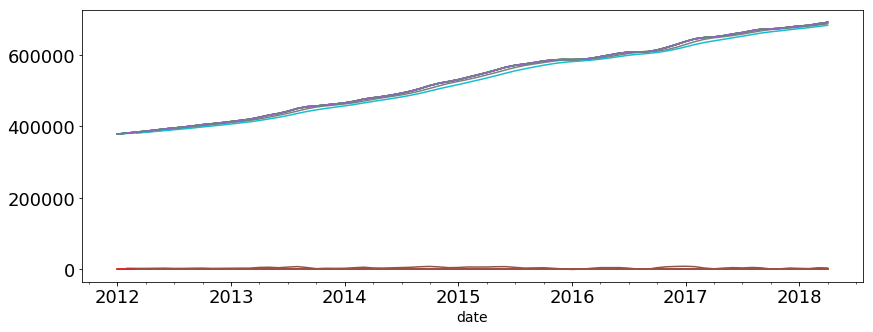

In [202]:
Trend_elimination(y)
# y_sqrt.plot()


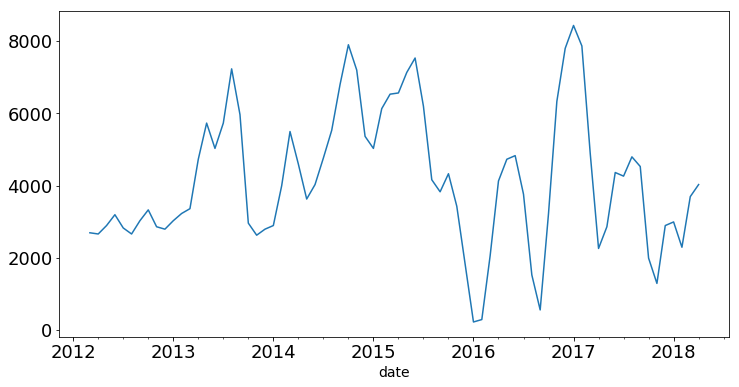

In [203]:
data_roll_mean = y.rolling(window=3).mean()
y_rmean_diff = y - data_roll_mean
y_rmean_diff.dropna(inplace=True)
fig = plt.figure(figsize=(12,6))
# y.plot()
# data_roll_mean.plot()
y_rmean_diff.plot()

# data_roll_mean = (np.log(y)).rolling(window=3).mean()
# fig = plt.figure(figsize=(12,6))
# y.plot()
# data_roll_mean.plot()

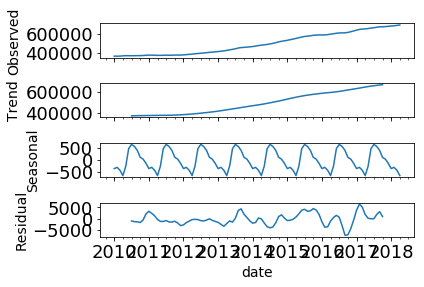

In [165]:
decomp = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomp.plot()

# ACF and PACF 

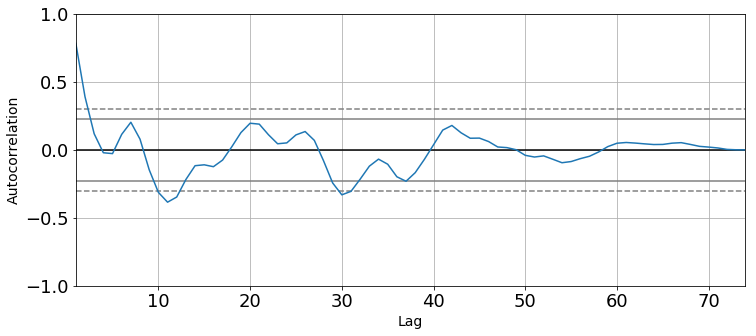

In [204]:
plt.figure(figsize=(12,5))
pd.plotting.autocorrelation_plot(y_rmean_diff);

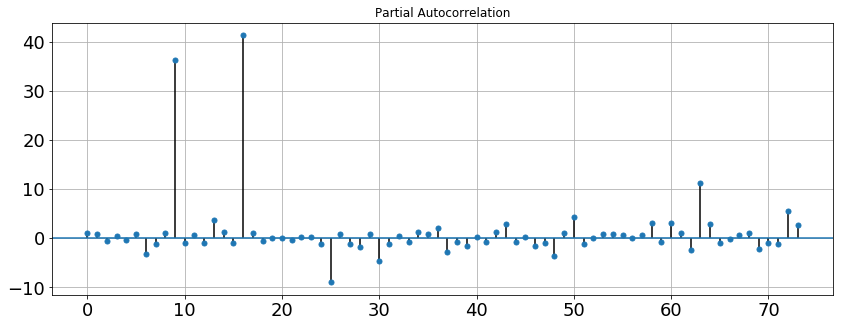

In [205]:
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 14, 5

plot_pacf(y_rmean_diff, lags = 250);
plt.grid(True)

In [214]:
p = d =range(0,2)
q = range(6,8)
pdq = list(itertools.product(p,d,q))
seasonal_pdq = [(x[0], x[1],x[2],12) for x in list(itertools.product(p, d, q))]

[(0, 0, 6, 12),
 (0, 0, 7, 12),
 (0, 1, 6, 12),
 (0, 1, 7, 12),
 (1, 0, 6, 12),
 (1, 0, 7, 12),
 (1, 1, 6, 12),
 (1, 1, 7, 12)]

In [212]:
mod = sm.tsa.statespace.SARIMAX(y[ycut:],
                                            order=(0,0,0),
                                            seasonal_order=(0,0,0,12),
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  20002   No. Observations:                   76
Model:                        SARIMAX   Log Likelihood               -1097.101
Date:                Tue, 18 Jun 2019   AIC                           2196.202
Time:                        10:45:23   BIC                           2198.520
Sample:                    01-01-2012   HQIC                          2197.128
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.953e+11   1.93e+11      1.527      0.127   -8.38e+10    6.74e+11
===================================================================================
Ljung-Box (Q):                      811.68   Jarque-Bera (JB):                 5.61
Prob(Q):                              0.00   Prob(JB):                         0.06
Heteroskedasticity (H):               2.33   Skew:                            -0.04
Prob(H) (two-sided):                  0.04   Kurtosis:                         1.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## SARIMAX Model

In [217]:
lowest_AIC =1e14

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
#             mod = ARIMA(y, order=param)
            print('ARIMA{}x{} '.format(param,param_seasonal)
            mod = sm.tsa.statespace.SARIMAX(y[ycut:],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()

            print('ARIMA{}x{} - AIC:{}'.format(param,
                                           param_seasonal, 
                                           results.aic))            
#             print('ARIMA{} - AIC:{}'.format(param,results.aic))

            if results.aic < lowest_AIC:
                lowest_AIC = results.aic
                print('ARIMA{}x{} - AIC:{}'.format(param,
                                               param_seasonal, 
                                               results.aic))
                print('\t low **************')  
        except:
            continue

SyntaxError: invalid syntax (<ipython-input-217-085328b833fd>, line 8)

In [42]:
# from statsmodels.tsa.arima_model import ARIMA
# mod = ARIMA(y,order=(2,0,2)) 

mod = sm.tsa.statespace.SARIMAX(y, 
                               order=(1,1,2),
                               seasonal_order=(2,2,1,12),
                               enforce_stationarity=False, 
                               enforse_invertibility=False)
results = mod.fit()
results.summary()

# results.plot_diagnostics(figsize=(16,8))
# plt.show()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              20002   No. Observations:                   76
Model:             SARIMAX(1, 1, 2)x(2, 2, 1, 12)   Log Likelihood                -238.949
Date:                            Mon, 17 Jun 2019   AIC                            491.897
Time:                                    22:45:20   BIC                            500.704
Sample:                                01-01-2012   HQIC                           494.433
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0341      0.999      0.034      0.973      -1.923       1.991
ma.L1          1.3515      0.488      2.772      0.006       0.396       2.307
ma.L2          0.5258      0.276      1.902      0.057      -0.016       1.068
ar.S.L12      -1.1726      0.490     -2.392      0.017      -2.133      -0.212
ar.S.L24      -0.2338      0.332     -0.705      0.481      -0.884       0.416
ma.S.L12       0.2317      0.500      0.464      0.643      -0.748       1.211
sigma2      9.596e+06   4.42e-08   2.17e+14      0.000     9.6e+06     9.6e+06
===================================================================================
Ljung-Box (Q):                       30.60   Jarque-Bera (JB):                 0.97
Prob(Q):                              0.20   Prob(JB):                         0.62
Heteroskedasticity (H):               1.71   Skew:                             0.21
Prob(H) (two-sided):                  0.44   Kurtosis:                         2.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.11e+30. Standard errors may be unstable.
"""

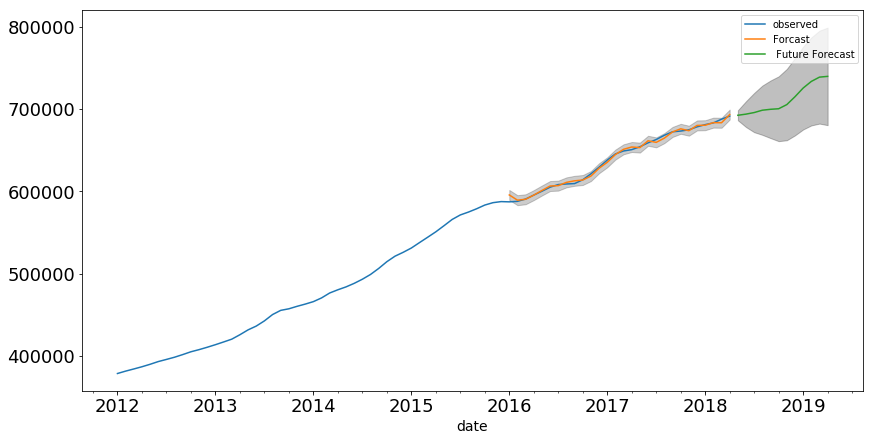

In [43]:
pred = results.get_prediction(start=pd.to_datetime('2016-01-01'),
                             dynamic=False)
pred_ci = pred.conf_int() 



ax = y.plot(label='observed')
pred.predicted_mean.plot(ax = ax, label='Forcast',figsize=(14,7))
ax.fill_between(pred_ci.index,
               pred_ci.iloc[:,0],
               pred_ci.iloc[:,1], color='k', alpha=0.2)

pred_future = results.get_forecast(steps=12)
pred_ci2 = pred_future.conf_int()

pred_future.predicted_mean.plot(ax=ax, label=' Future Forecast')
ax.fill_between(pred_ci2.index, 
               pred_ci2.iloc[:,0],
               pred_ci2.iloc[:,1], color='k',alpha = 0.25)
plt.legend()